<a href="https://colab.research.google.com/github/Alonge9500/Hamoye-Fall_Internship-2022/blob/main/Hamoye_stage_E_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
#Import Libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
import numpy as np
from sklearn.metrics import mean_absolute_error,mean_squared_error


In [67]:
data = pd.read_csv("https://github.com/HamoyeHQ/HDSC-Time-series-analysis-and-forecast/files/7768846/Time_series_analysis_and_forecast_DATASET.csv")

In [68]:
data.head()

,FullDate,Tmax,SysLoad,GasPrice,ElecPrice
0,2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
1,2010-09-01 01:00:00,15.8,1669.195,3.69,22.635
2,2010-09-01 02:00:00,15.8,1491.980,3.69,22.565
3,2010-09-01 03:00:00,15.8,1330.760,3.69,18.910
4,2010-09-01 04:00:00,15.8,1247.940,3.69,18.030


In [69]:
data['FullDate'] = pd.to_datetime(data.FullDate)
data.set_index('FullDate',inplace=True)

data = data.resample('D').sum()

data.head()

,Tmax,SysLoad,GasPrice,ElecPrice
FullDate,,,,
2010-09-01,379.2,41565.380,88.56,2751.700
2010-09-02,369.6,38898.990,88.56,570.810
2010-09-03,439.2,41665.760,106.80,504.975
2010-09-04,328.8,35638.085,81.36,502.275
2010-09-05,357.6,35611.410,106.80,500.555


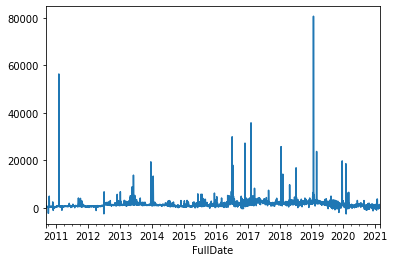

In [70]:
data.ElecPrice.plot()

In [71]:
from statsmodels.tsa.stattools import adfuller

# load the data
sys_load = data.SysLoad
gas_price = data.GasPrice

# perform the ADF test on sys_load data
result_sys = adfuller(sys_load)
pvalue_sys = result_sys[1]

# perform the ADF test on gas_price data
result_gas = adfuller(gas_price)
pvalue_gas = result_gas[1]

# print the p-values
print("P-value for SysLoad: {:.6f}".format(pvalue_sys))
print("P-value for GasPrice: {:.6f}".format(pvalue_gas))


P-value for SysLoad: 0.004254
P-value for GasPrice: 0.045027


In [72]:
elec_price = data.ElecPrice


result_gas = adfuller(gas_price, maxlag=None, regression='c', autolag='AIC')
critical_values_gas = result_gas[4]

result_elec = adfuller(elec_price, maxlag=None, regression='c', autolag='AIC')
critical_values_elec = result_elec[4]

print("Critical Values for GasPrice:")
print("10%: {:.4f}".format(critical_values_gas['10%']))
print("5%: {:.4f}".format(critical_values_gas['5%']))
print("Critical Values for ElecPrice:")
print("10%: {:.4f}".format(critical_values_elec['10%']))
print("5%: {:.4f}".format(critical_values_elec['5%']))


Critical Values for GasPrice:
10%: -2.5672
5%: -2.8623
Critical Values for ElecPrice:
10%: -2.5672
5%: -2.8623


In [73]:
def compute_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [74]:
data = data.reset_index()

In [75]:
len(data)

3834

In [76]:
train1 = data[:2757]
test1 = data[2757:].reset_index(drop=True)


model1 = Prophet(daily_seasonality=True)

model1.fit(train1[['FullDate', 'ElecPrice']].rename(columns={'FullDate':'ds', 'ElecPrice':'y'}))

DEBUG:cmdstanpy:input tempfile: /tmp/tmpnute6oh6/efoqa1ou.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnute6oh6/tnsntjb4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16451', 'data', 'file=/tmp/tmpnute6oh6/efoqa1ou.json', 'init=/tmp/tmpnute6oh6/tnsntjb4.json', 'output', 'file=/tmp/tmpnute6oh6/prophet_modeljhis6a2b/prophet_model-20230128000847.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:08:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:08:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [77]:
future1 = test1.rename(columns={'FullDate':'ds'}).drop('ElecPrice',axis=1)
future1.head()
forecast1 = model1.predict(future1)
future1.ds

0      2018-03-20
1      2018-03-21
2      2018-03-22
3      2018-03-23
4      2018-03-24
          ...    
1072   2021-02-24
1073   2021-02-25
1074   2021-02-26
1075   2021-02-27
1076   2021-02-28
Name: ds, Length: 1077, dtype: datetime64[ns]

In [78]:
yhat1 = list(forecast1.yhat)
y1 = list(test1.ElecPrice)

In [79]:
compute_mape(y1,yhat1)

541.4781284881942

In [80]:
def rmse(forecast, actual):
    forecast = np.array(forecast)
    actual = np.array(actual)
    return np.sqrt(np.mean((forecast - actual)**2))


rmse(yhat1,y1)

3201.588694657618

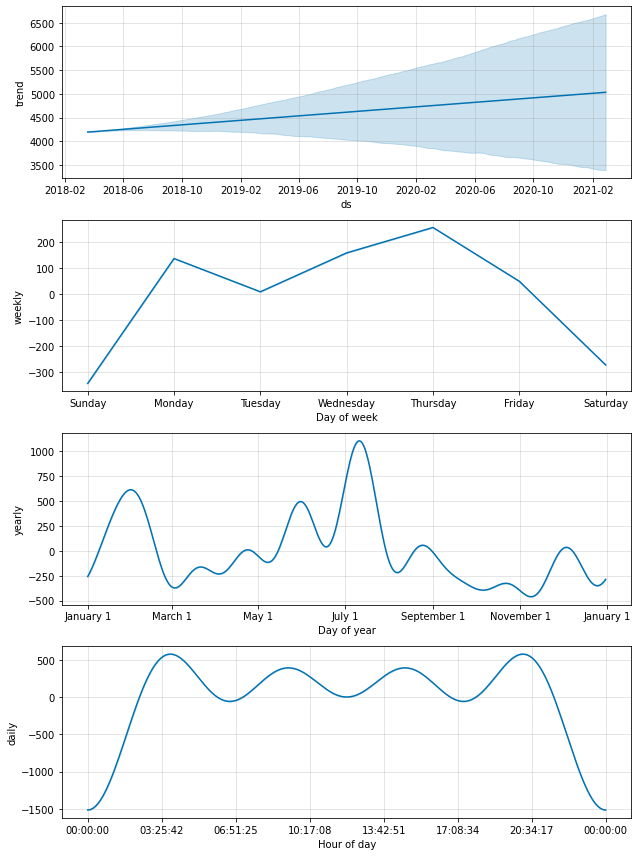

In [81]:
model1.plot_components(forecast1)
plt.show()

In [82]:

train = data[:2757].reset_index(drop=True)
test = data[2757:].reset_index(drop=True)

# Initialize the model
model = Prophet(daily_seasonality=True)

# Add the additional independent variables as regressors
model.add_regressor('SysLoad')
model.add_regressor('Tmax')
model.add_regressor('GasPrice')

model = model.fit(train[['FullDate', 'ElecPrice', 'SysLoad', 'Tmax', 'GasPrice']].rename(columns={'FullDate':'ds', 'ElecPrice':'y'}))

DEBUG:cmdstanpy:input tempfile: /tmp/tmpnute6oh6/17_7c096.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnute6oh6/2hgyprgh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38238', 'data', 'file=/tmp/tmpnute6oh6/17_7c096.json', 'init=/tmp/tmpnute6oh6/2hgyprgh.json', 'output', 'file=/tmp/tmpnute6oh6/prophet_modelrz_ljbh4/prophet_model-20230128000850.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:08:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:08:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [83]:
future = test.rename(columns={'FullDate':'ds'}).drop('ElecPrice',axis=1)
future.head()

,ds,Tmax,SysLoad,GasPrice
0,2018-03-20,540.0,7696.91130,201.5880
1,2018-03-21,571.2,4658.05865,203.2560
2,2018-03-22,722.4,19161.78525,203.2560
3,2018-03-23,811.2,18090.43435,198.6456
4,2018-03-24,832.8,3763.53865,180.2160


In [84]:
forecast = model.predict(future)

In [85]:
yhat = list(forecast.yhat)
y=list(test['ElecPrice'])

In [86]:
compute_mape(y,yhat)

230.08701038923806

In [87]:
rmse(yhat,y)

2705.7130679481106

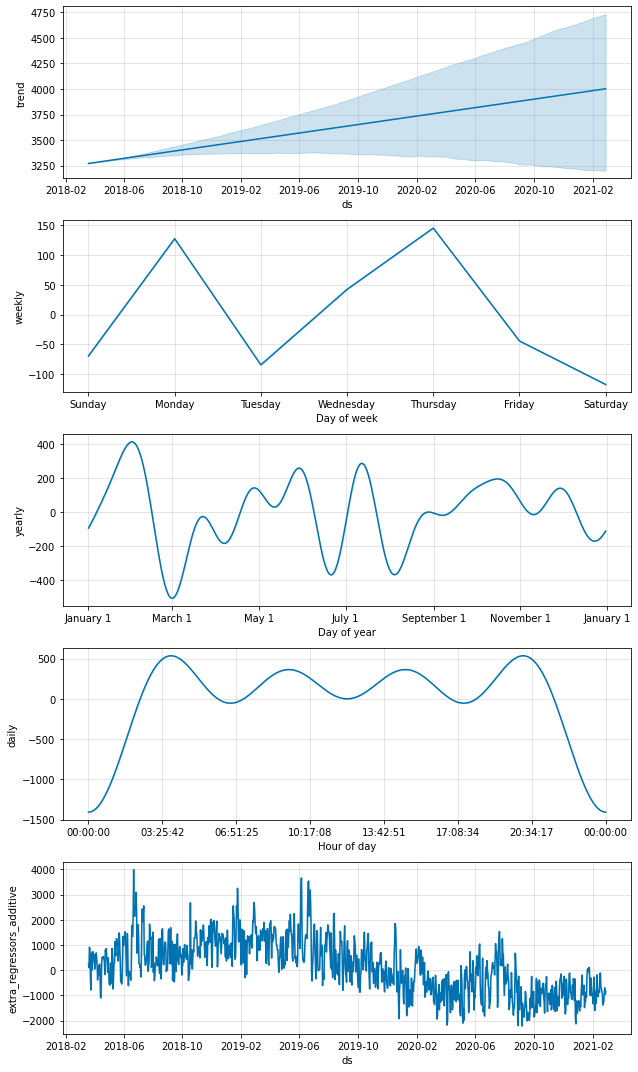

In [88]:
model.plot_components(forecast)
plt.show()

In [89]:

train3 = data[:2757].drop('Tmax',axis=1).reset_index(drop=True)
test3 = data[2757:].drop('Tmax',axis=1).reset_index(drop=True)

model3 = Prophet(daily_seasonality=True)


model3.add_regressor('SysLoad')
model3.add_regressor('GasPrice')

model3 = model3.fit(train3[['FullDate', 'ElecPrice', 'SysLoad', 'GasPrice']].rename(columns={'FullDate':'ds', 'ElecPrice':'y'}))

DEBUG:cmdstanpy:input tempfile: /tmp/tmpnute6oh6/pkk4iyzb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnute6oh6/zwz1k3ji.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60243', 'data', 'file=/tmp/tmpnute6oh6/pkk4iyzb.json', 'init=/tmp/tmpnute6oh6/zwz1k3ji.json', 'output', 'file=/tmp/tmpnute6oh6/prophet_modelfxrlwcqf/prophet_model-20230128000853.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:08:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:08:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [90]:
future3 = test3.rename(columns={'FullDate':'ds'}).drop('ElecPrice',axis=1)
future3.head()

,ds,SysLoad,GasPrice
0,2018-03-20,7696.91130,201.5880
1,2018-03-21,4658.05865,203.2560
2,2018-03-22,19161.78525,203.2560
3,2018-03-23,18090.43435,198.6456
4,2018-03-24,3763.53865,180.2160


In [91]:
forecast3 = model3.predict(future3)

In [92]:
y3 = test3.ElecPrice
yhat3 = forecast3.yhat

compute_mape(y3,yhat3)

232.42257591477335